# Assignment 1

## Question 1: Think about a meaningful real-world application for this problem and briefly describe it

Application: Railway Scheduling and Track Layout

- Nodes in $U$ could represent fixed train stations along a route, where trains must stop in a specific order
- Nodes in $V$ could reoresent trains/train routes to be scheduled within the network
- Weighetd edges would inidcate the relationship between trains/train routes and tracks, with higher weights representing either higher traffic, longer distance, lower importance in terms of scheduling (in case of for exaple local vs. high speed train)
- constraints in C would enforce rules like the fact that certain trains need to arrive before others or that trains using the same tracks do not overlap.

The objective then would be to arrange the schedules in V to minimize the crossings of tracks while satisfying all contraints in C. This would lead to improved security and efficiency as minimzing track crossings would reduce the likelihood of collisions or delaysdue to track conflicts.

## Question 2: Develop a meaningful deterministic construction heuristic

A meaningful determinitic contruction heuristic could be one based on a greedy approach:
- Inititalize an empty ordered permuation list $\pi$ for nodes in $V$
- Sort the nodes in $V$ based on the precedence constraints in $C$
- For every node in $U$ and until $V$ is empty
  - look at which nodes in $V$ are connected to it and choose one based on two criteria:
    - precedence constraint satisfaction
    - cost of placing $v$ in that position ($p$), which is based on the sum of the weights of all edges that would cross if $v$ is placed in $p$
  - Add this node to the ordered list $\pi$ in the specified position and remove it from $V$

- At the end check all contraints are satisfied and if not backtrack to put nodes in a position where they satisfy them


## Question 3: Derive a randomized construction heuristic to be applied iteratively

The randomized heuristic could follow the same process as the deterministic one, but then, when choosing the node in $V$ to connect to a node in $U$, instead of always choosing the one that has a minimum cost if inserted in that position, we could pick one randomly, with a probability inversely propotional to the cost.

In [106]:
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict, deque

class Graph:
    def __init__(self, U_size, V_size):
        self.U = list(range(1, U_size + 1))  # Nodes in set U
        self.V = list(range(U_size + 1, U_size + V_size + 1))  # Nodes in set V
        self.edges = []  # List of edges (u, v, weight)
        self.constraints = []  # List of precedence constraints (v, v')
        self.pos = {node: idx for idx, node in enumerate(self.U)}  # Position of nodes in U
        self.pos.update({node: (1, i) for i, node in enumerate(self.V)})  # Position of nodes in V

    def add_edge(self, u, v, weight):
        self.edges.append((u, v, weight))

    def add_constraint(self, v1, v2):
        self.constraints.append((v1, v2))

    def crossing_cost(self):
        crossings = 0
        for (u1, v1, w1), (u2, v2, w2) in itertools.combinations(self.edges, 2):
            if u1 < u2 and self.pos[v1] > self.pos[v2]:
                crossings += w1 + w2
            elif u1 > u2 and self.pos[v1] < self.pos[v2]:
                crossings += w1 + w2
        return crossings


    def visualize(self):
        G = nx.Graph()

        # Add nodes for U and V
        G.add_nodes_from(self.U, bipartite=0)
        G.add_nodes_from(self.V, bipartite=1)

        # Add edges with weights as labels
        for u, v, weight in self.edges:
            G.add_edge(u, v, weight=weight)

        # Create positions for bipartite layout
        pos = {node: (0, i) for i, node in enumerate(self.U)}
        pos.update({node: (1, i) for i, node in enumerate(self.V)})

        plt.figure(figsize=(10, 6))
        edge_labels = {(u, v): f"{weight}" for u, v, weight in self.edges}
        nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        plt.title("Initial Bipartite Graph")
        plt.show()

In [107]:
def load_instance(filename):
    with open(filename, 'r') as file:
        U_size, V_size, C_size, E_size = map(int, file.readline().split())
        graph = Graph(U_size, V_size)

        # Read constraints section
        line = file.readline().strip()
        while line != "#constraints":
            line = file.readline().strip()

        for _ in range(C_size):
            v, v_prime = map(int, file.readline().split())
            graph.add_constraint(v, v_prime)

        # Read edges section
        line = file.readline().strip()
        while line != "#edges":
            line = file.readline().strip()

        for _ in range(E_size):
            u, v, weight = file.readline().split()
            graph.add_edge(int(u), int(v), float(weight))

    return graph

### Construction

In [187]:
class HeuristicSol:
    def __init__(self, graph, permutation=None):
        self.graph = graph
        self.permutation = permutation if permutation is not None else self.deterministic_construction()
        self.pos = {node: idx for idx, node in enumerate(self.permutation)}

    def deterministic_construction(self):
        permutation = []
        nodes_in_V = set(self.graph.V)

        while nodes_in_V:
            best_node, min_cost = None, float('inf')

            for u in self.graph.U:
                candidate_nodes = [v for v in nodes_in_V if (u, v) in [(e[0], e[1]) for e in self.graph.edges]]

                for v in candidate_nodes:
                    cost = self.calculate_crossing_cost(permutation, v)
                    if cost < min_cost:
                        best_node, min_cost = v, cost

            if best_node is not None:
                permutation.append(best_node)
                nodes_in_V.remove(best_node)

        # After constructing the initial permutation, adjust it to ensure all constraints are satisfied
        return self.reposition_to_satisfy_constraints(permutation)

    def reposition_to_satisfy_constraints(self, permutation):
        for idx, node in enumerate(permutation):
            for v1, v2 in self.graph.constraints:
                # Ensure v1 appears before v2
                if v1 == node:
                    pos_v1 = idx
                    pos_v2 = permutation.index(v2) if v2 in permutation else None

                    # If v1 appears after v2, reposition v1 to satisfy the constraint
                    if pos_v2 is not None and pos_v1 > pos_v2:
                        # Remove and reinsert v1 before v2
                        permutation.remove(v1)
                        permutation.insert(pos_v2, v1)

        return permutation


    def calculate_crossing_cost(self, current_permutation, v):
        pos = len(current_permutation)
        crossing_cost = 0

        for u, v2, weight in self.graph.edges:
            if v2 == v:
                for u1, v1, weight1 in self.graph.edges:
                    if v1 in current_permutation:
                        idx_v1 = current_permutation.index(v1)
                        if (u1 < u and idx_v1 > pos) or (u1 > u and idx_v1 < pos):
                            crossing_cost += weight + weight1
        return crossing_cost

    def is_feasible(self):
        violations = 0
        for v, v_prime in self.graph.constraints:
            if self.pos[v] >= self.pos[v_prime]:
                violations += 1
        return violations == 0, violations

    def count_crossings(self):
        crossings = 0
        for (u1, v1, w1), (u2, v2, w2) in itertools.combinations(self.graph.edges, 2):
            if u1 < u2 and self.pos[v1] > self.pos[v2]:
                crossings += w1 + w2
            elif u1 > u2 and self.pos[v1] < self.pos[v2]:
                crossings += w1 + w2
        return crossings

    def visualize(self):
        G = nx.Graph()

        G.add_nodes_from(self.graph.U, bipartite=0)
        G.add_nodes_from(self.graph.V, bipartite=1)

        for u, v, weight in self.graph.edges:
            G.add_edge(u, v, weight=weight)

        pos = {node: (0, i) for i, node in enumerate(self.graph.U)}
        pos.update({node: (1, self.pos[node]) for node in self.graph.V})

        plt.figure(figsize=(10, 6))
        edge_labels = {(u, v): f"{weight}" for u, v, weight in self.graph.edges}

        nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        plt.title("Bipartite Graph Visualization with Current Ordering of V")
        plt.show()


In [188]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict, deque

class HeuristicSol:
    def __init__(self, graph, permutation=None):
        self.graph = graph
        self.permutation = permutation if permutation is not None else self.deterministic_construction()
        self.pos = {node: idx for idx, node in enumerate(self.permutation)}

    def deterministic_construction(self):
        permutation = []
        nodes_in_V = set(self.graph.V)

        while nodes_in_V:
            best_node, min_cost = None, float('inf')

            for u in self.graph.U:
                candidate_nodes = [v for v in nodes_in_V if (u, v) in [(e[0], e[1]) for e in self.graph.edges]]

                for v in candidate_nodes:
                    cost = self.calculate_crossing_cost(permutation, v)
                    if cost < min_cost:
                        best_node, min_cost = v, cost

            if best_node is not None:
                permutation.append(best_node)
                nodes_in_V.remove(best_node)

        # After constructing the initial permutation, adjust it to ensure all constraints are satisfied
        permutation = self.reposition_to_satisfy_constraints(permutation)
        return permutation

    def reposition_to_satisfy_constraints(self, permutation):
        """Enforce constraints in the final permutation by recalculating optimal positions."""
        changed = True
        while changed:
            changed = False
            for v1, v2 in self.graph.constraints:
                pos_v1 = permutation.index(v1) if v1 in permutation else None
                pos_v2 = permutation.index(v2) if v2 in permutation else None

                # If v1 appears after v2, we need to reposition v1
                if pos_v1 is not None and pos_v2 is not None and pos_v1 > pos_v2:
                    # Calculate potential positions for v1
                    valid_positions = [i for i in range(len(permutation)) if self.is_valid_position(permutation, v1, v2, i)]

                    # Choose the best valid position based on crossing cost
                    best_position = min(valid_positions, key=lambda pos: self.calculate_crossing_cost(permutation[:pos] + [v1] + permutation[pos:], v1))

                    # Remove and reinsert v1 at the best position
                    permutation.remove(v1)
                    permutation.insert(best_position, v1)
                    changed = True  # Mark that a change has been made to continue checking

                    # Update position mapping after modification
                    self.update_position_map(permutation)

        return permutation

    def is_valid_position(self, permutation, v1, v2, position):
        """Check if placing v1 at the given position respects the constraint v1 before v2."""
        pos_v2 = permutation.index(v2)
        return position < pos_v2

    def update_position_map(self, permutation):
        """Update the position mapping after changes in the permutation."""
        self.pos = {node: idx for idx, node in enumerate(permutation)}

    def calculate_crossing_cost(self, current_permutation, v):
        pos = len(current_permutation)
        crossing_cost = 0

        for u, v2, weight in self.graph.edges:
            if v2 == v:
                for u1, v1, weight1 in self.graph.edges:
                    if v1 in current_permutation:
                        idx_v1 = current_permutation.index(v1)
                        if (u1 < u and idx_v1 > pos) or (u1 > u and idx_v1 < pos):
                            crossing_cost += weight + weight1
        return crossing_cost

    def is_feasible(self):
        violations = 0
        for v, v_prime in self.graph.constraints:
            if self.pos[v] >= self.pos[v_prime]:
                violations += 1
        return violations == 0, violations

    def count_crossings(self):
        crossings = 0
        for (u1, v1, w1), (u2, v2, w2) in itertools.combinations(self.graph.edges, 2):
            if u1 < u2 and self.pos[v1] > self.pos[v2]:
                crossings += w1 + w2
            elif u1 > u2 and self.pos[v1] < self.pos[v2]:
                crossings += w1 + w2
        return crossings

    def visualize(self):
        G = nx.Graph()

        G.add_nodes_from(self.graph.U, bipartite=0)
        G.add_nodes_from(self.graph.V, bipartite=1)

        for u, v, weight in self.graph.edges:
            G.add_edge(u, v, weight=weight)

        pos = {node: (0, i) for i, node in enumerate(self.graph.U)}
        pos.update({node: (1, self.pos[node]) for node in self.graph.V})

        plt.figure(figsize=(10, 6))
        edge_labels = {(u, v): f"{weight}" for u, v, weight in self.graph.edges}

        nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        plt.title("Bipartite Graph Visualization with Current Ordering of V")
        plt.show()


### Tests

Total weighted cost: 51.0


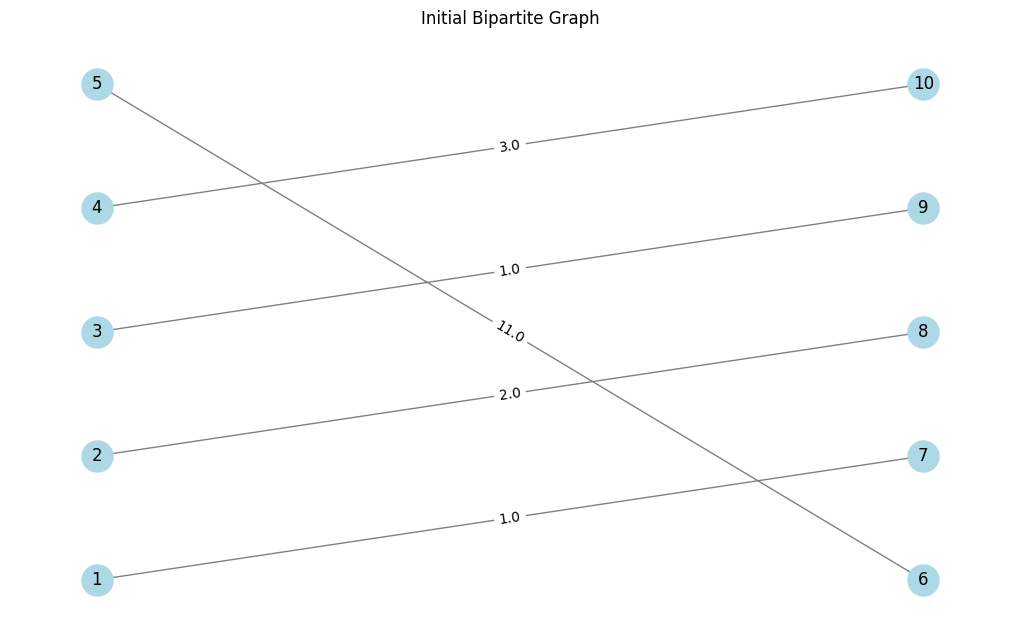



--------------------------------------
Solution
Final Permutation of V: [7, 8, 9, 10, 6]
Feasibility: Yes (Violations: 0)
Total Weighted Crossings: 0


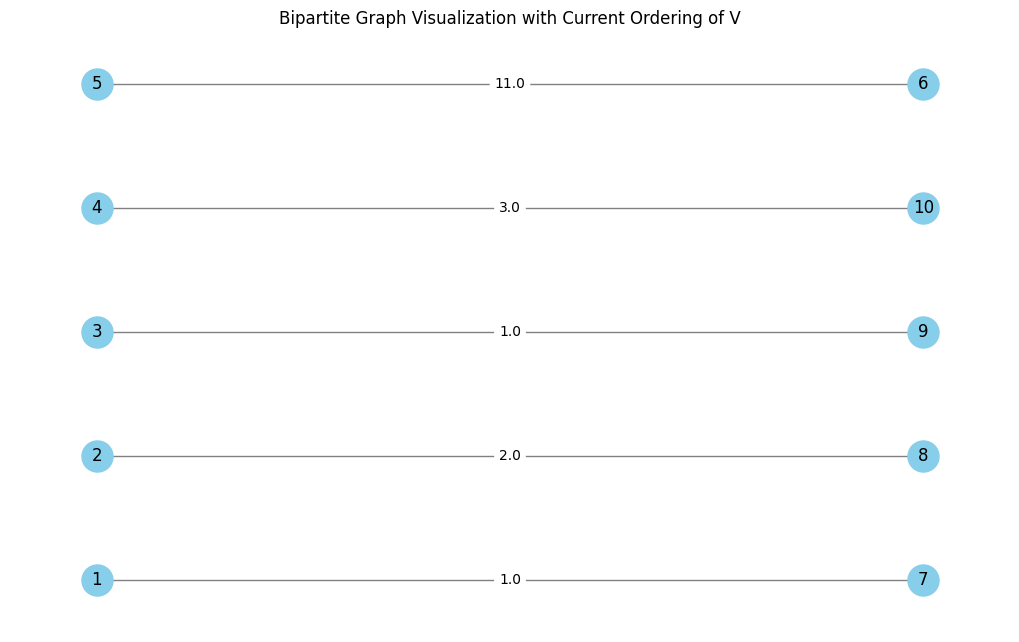

In [189]:
graph = load_instance('input_file.txt')
print("Total weighted cost:", graph.crossing_cost())
graph.visualize()

print("\n")
print("--------------------------------------")

print("Solution")
# Construct a solution
solution = HeuristicSol(graph)

# Print results
print("Final Permutation of V:", solution.permutation)
feasible, violations = solution.is_feasible()
crossings = solution.count_crossings()

print(f"Feasibility: {'Yes' if feasible else 'No'} (Violations: {violations})")
print(f"Total Weighted Crossings: {crossings}")

solution.visualize()

In [190]:
graph = load_instance('in.txt')
print("Total weighted cost:", graph.crossing_cost())

Total weighted cost: 94241.0


Final Permutation of V: [31, 26, 48, 43, 27, 34, 39, 36, 49, 35, 30, 42, 37, 28, 38, 46, 32, 45, 47, 41, 40, 50, 33, 44, 29]
Feasibility: Yes (Violations: 0)
Total Weighted Crossings: 100412.0


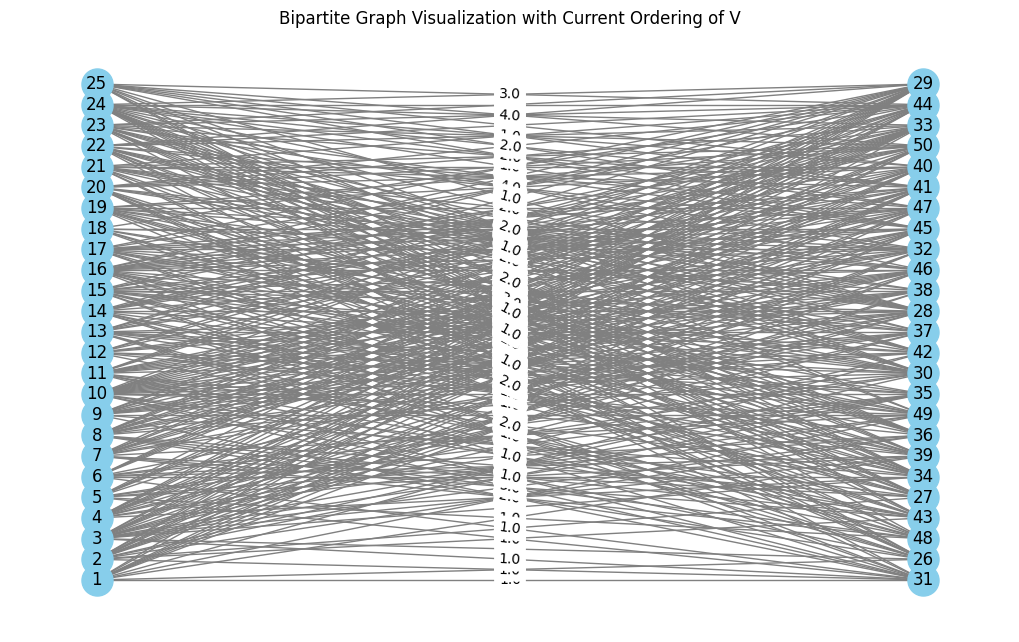

In [191]:
solution = HeuristicSol(graph)
feasible, violations = solution.is_feasible()
crossings = solution.count_crossings()

print("Final Permutation of V:", solution.permutation)
print(f"Feasibility: {'Yes' if feasible else 'No'} (Violations: {violations})")
print(f"Total Weighted Crossings: {crossings}")

solution.visualize()